### Pneumonia 

The data are available: https://data.mendeley.com/datasets/rscbjbr9sj/2

#### Import libraries 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import time
import copy
import random
import os 
import cv2
from matplotlib.image import imread
%matplotlib inline

In [2]:
# Set the device to gpu if available 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
# function to print images
def print_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize = (2.5, 2.5))
    plt.axis('off')
    plt.imshow(img)

In [4]:
# creates a transform sequence for the train set
transf_train = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(225),
    transforms.ToTensor(), # converts pixels [0-255] to tensors [0-1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

# creates a second transform sequence for the train set
transf_train2 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.RandomCrop(225),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# creates a third transform sequence for the train set
transf_train3 = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(225),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(translate=(0.08,0.1), degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# creates the transform sequence for the test and val sets
transf_test = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(225),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])


# loads the images and applies the transformations
train_set = torchvision.datasets.ImageFolder('train', transform = transf_train)
train_set2 = torchvision.datasets.ImageFolder('train', transform = transf_train2)
train_set3 = torchvision.datasets.ImageFolder('train', transform = transf_train3)
test_set = torchvision.datasets.ImageFolder('test', transform = transf_test)
val_set = torchvision.datasets.ImageFolder('val', transform = transf_test)



# number of images in each set
train_size = len(train_set)
test_size = len(test_set)
val_size = len(val_set)
print('Train: {} images, Test: {} images, Validation: {} images'.format(train_size, test_size, val_size))

Train: 5216 images, Test: 624 images, Validation: 16 images


In [5]:
# class labels
class_names = train_set.classes

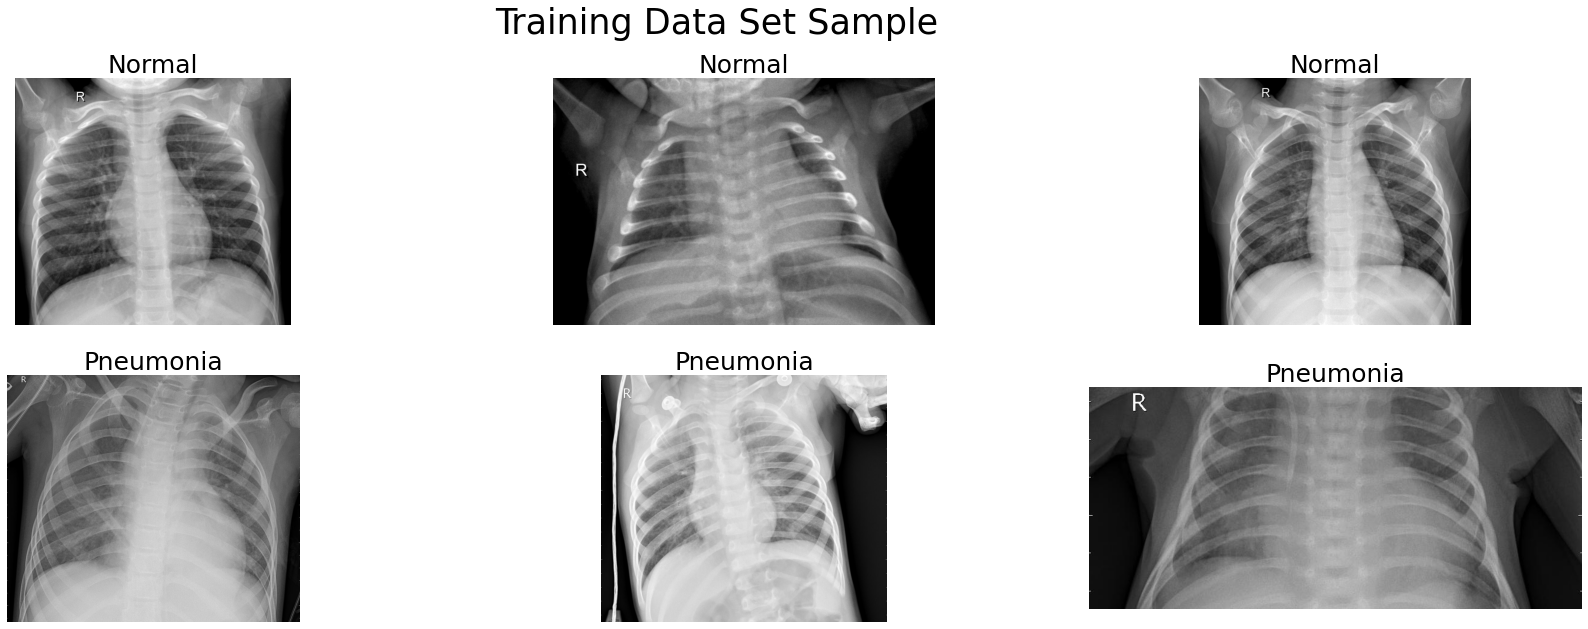

In [6]:
# Function for plotting some samples
data_dir = 'chest_xray'


def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,10))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//3][i%3].imshow(image)
        if i<3:
            ax[i//3][i%3].set_title("Normal", fontsize=25)
        else:
            ax[i//3][i%3].set_title("Pneumonia", fontsize=25)
        ax[i//3][i%3].axis('off')
        
        
## Plot training dataset samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 3) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 3)

plot_samples(rand_samples)
plt.suptitle('Training Data Set Sample', fontsize=35)
plt.show()   

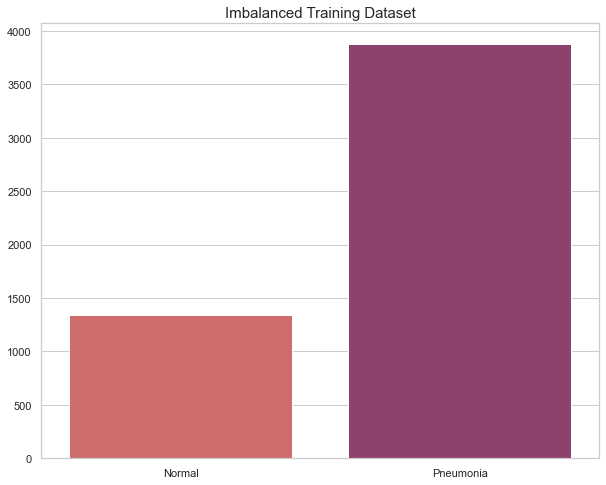

In [7]:
# number of images for each class

plt.figure(figsize = (10,8))

sns.set_theme(style="whitegrid")

# Plot the length of the list of files from the directories 
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]
    }
)

sns.barplot(data=train_samplesize,  palette="flare").set_title('Imbalanced Training Dataset', fontsize=15)
plt.show()

In [8]:
# Set the path for the data 
path = 'chest_xray'

#### Count the datasets per class

In [9]:
counter = []
x_norm = 0
x_pneu = 0

for i in train_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_pneu += 1
    else:
        counter.append("Normal")
        x_norm += 1

print('Train set')
print('Normal:', x_norm, '/ Pneumonia:', x_pneu)


Train set
Normal: 1341 / Pneumonia: 3875


In [10]:
counter = []
x_norm = 0
x_pneu = 0

for i in test_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_pneu += 1
    else:
        counter.append("Normal")
        x_norm += 1

print('Test set')
print('Normal:', x_norm, '/ Pneumonia:', x_pneu)

Test set
Normal: 234 / Pneumonia: 390


In [11]:
counter = []
x_norm = 0
x_pneu = 0

for i in val_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_pneu += 1
    else:
        counter.append("Normal")
        x_norm += 1

print('Validation set')
print('Normal:', x_norm, '/ Pneumonia:', x_pneu)

Validation set
Normal: 8 / Pneumonia: 8


##### Augment train dataset 

In [12]:
train_set2, _ = train_test_split(train_set2, test_size= 3875/train_size, shuffle=False)

train_set3, _ = train_test_split(train_set3, test_size= 4023/train_size, shuffle=False)

train_set = ConcatDataset([train_set, train_set2, train_set3])


In [13]:
counter = []
x_norm = 0
x_pneu = 0

for i in train_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_pneu += 1
    else:
        counter.append("Normal")
        x_norm += 1

print('Train set')
print('Normal:', x_norm, '/ Pneumonia:', x_pneu)

Train set
Normal: 3875 / Pneumonia: 3875


Now the dataset is balanced 

In [14]:
# Create validation set because  16 pictures are not enough 

train_set, val_set = train_test_split(train_set, test_size=0.2)

train_size = len(train_set)
val_size = len(val_set)


In [15]:
# Create loaders 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32, shuffle = True, num_workers = 8)


### Model 

In [16]:
# import pretrained model
model = torchvision.models.resnet152(pretrained = True)

# Turn off updating all the layes 
for param in model.parameters():
    param.requires_grad = False

# number of features in the input of the linear layer
num_ftrs = model.fc.in_features

# sets the number of features of the linear layer
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
num_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model summary
summary(model, (3, 255, 255), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 128, 128]           9,408
       BatchNorm2d-2         [16, 64, 128, 128]             128
              ReLU-3         [16, 64, 128, 128]               0
         MaxPool2d-4           [16, 64, 64, 64]               0
            Conv2d-5           [16, 64, 64, 64]           4,096
       BatchNorm2d-6           [16, 64, 64, 64]             128
              ReLU-7           [16, 64, 64, 64]               0
            Conv2d-8           [16, 64, 64, 64]          36,864
       BatchNorm2d-9           [16, 64, 64, 64]             128
             ReLU-10           [16, 64, 64, 64]               0
           Conv2d-11          [16, 256, 64, 64]          16,384
      BatchNorm2d-12          [16, 256, 64, 64]             512
           Conv2d-13          [16, 256, 64, 64]          16,384
      BatchNorm2d-14          [16, 256,

In [17]:


# keep losses and accuracies for plotting 
Train_Acc = []
Val_Acc = []
Train_Loss = []
Val_Loss = []

# Function to convert cuda to list 
def lis(x): 
    z=[]
    for i in x:
        z.append(i.item())
    
    return z


# function to train the model
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        # train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        
        Train_Loss.append(epoch_loss)
        Train_Acc.append(epoch_acc)
        
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        

        
        # validate
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / val_size
        epoch_acc = running_corrects.double() / val_size
        
        Val_Loss.append(epoch_loss)
        Val_Acc.append(epoch_acc)
        
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 30)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict()) # Keep the best model 
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model) # keep the best model 
    
    return model


# function to predict images and display the accuracy
def visualize_predictions(model, dataset):
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            input, label = dataset[i]
            input = input[np.newaxis,:]
            input = input.to(device)
            output = model(input)
            _, preds = torch.max(output, 1)
            if class_names[label] == class_names[preds]:
                acc += 1
            labels.append(class_names[label])
            predictions.append(class_names[preds])
    print('Test Accuracy: {:.4f}'.format(acc/len(dataset)))
    model.train(mode=was_training)
    return labels, predictions

In [18]:
# train the model
model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/30
Train Loss: 0.4503 Train Acc: 0.8460
Val Loss: 0.3177 Val Acc: 0.9123
------------------------------
Epoch 2/30
Train Loss: 0.2782 Train Acc: 0.9171
Val Loss: 0.2453 Val Acc: 0.9258
------------------------------
Epoch 3/30
Train Loss: 0.2240 Train Acc: 0.9316
Val Loss: 0.1995 Val Acc: 0.9258
------------------------------
Epoch 4/30
Train Loss: 0.2000 Train Acc: 0.9381
Val Loss: 0.1795 Val Acc: 0.9361
------------------------------
Epoch 5/30
Train Loss: 0.1896 Train Acc: 0.9365
Val Loss: 0.1659 Val Acc: 0.9400
------------------------------
Epoch 6/30
Train Loss: 0.1701 Train Acc: 0.9444
Val Loss: 0.1566 Val Acc: 0.9419
------------------------------
Epoch 7/30
Train Loss: 0.1639 Train Acc: 0.9440
Val Loss: 0.1489 Val Acc: 0.9426
------------------------------
Epoch 8/30
Train Loss: 0.1517 Train Acc: 0.9476
Val Loss: 0.1427 Val Acc: 0.9458
------------------------------
Epoch 9/30
Train Loss: 0.1476 Train Acc: 0.9500
Val Loss: 0.1381 Val Acc: 0.9465
-----------------------

## Plot the Results 

In [19]:
Train_Acc1 = lis(Train_Acc)

Val_Acc1 = lis(Val_Acc)

Text(0.5, 1.0, 'Loss')

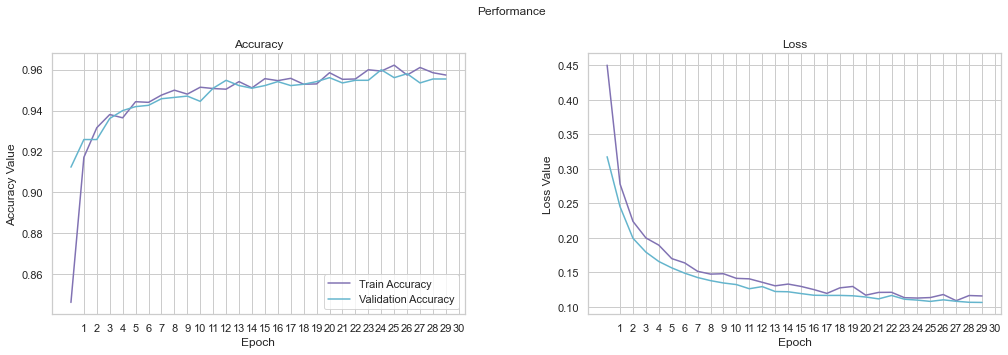

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(num_epochs))
ax1.plot(epoch_list, Train_Acc1, color='m', label='Train Accuracy')
ax1.plot(epoch_list, Val_Acc1, color='c' ,label='Validation Accuracy')
ax1.set_xticks(np.arange(1, num_epochs+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, Train_Loss, color='m', label='Train Loss')
ax2.plot(epoch_list, Val_Loss, color='c', label='Validation Loss')
ax2.set_xticks(np.arange(1, num_epochs+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')

In [21]:
# predicting the test set
labels, predictions = visualize_predictions(model, test_set)

Test Accuracy: 0.8285


<Figure size 432x288 with 0 Axes>

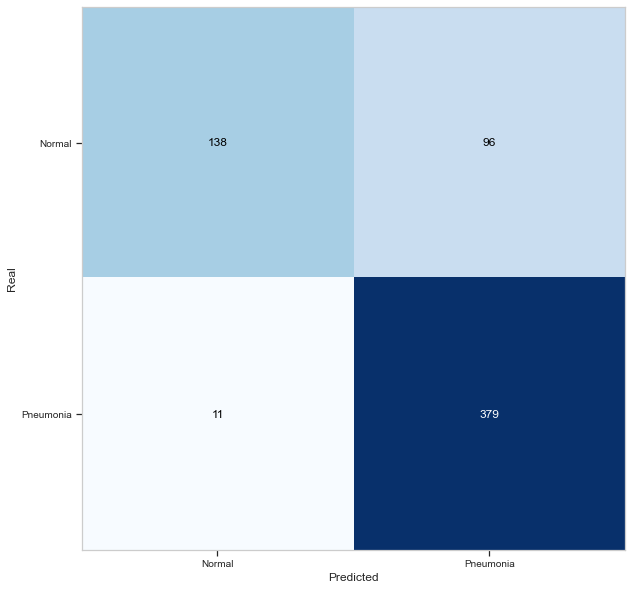

In [22]:
# confusion matrix
matrix = confusion_matrix(labels, predictions)
plt.figure()
plot_confusion_matrix(matrix, figsize=(10,10))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

Accuracy in medical problems is not crucial since our task is to predict pneumonia and thus the recall of Pneumonia is important.

In [23]:
# Compute Performance Metrics
tn, fp, fn, tp = matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Recall of the model is 0.97
Precision of the model is 0.80
F1 Score of the model is 0.88
